In [1]:
import pandas as pd
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import numpy as np
import geopandas as gpd
import os
import contextily as ctx
import imageio
from shapely.geometry import Point

In [2]:
input_path = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\Data_Clustered_Cleaned.csv"

# Read the CSV file into a DataFrame
df_merged = pd.read_csv(input_path, low_memory=False)

## Temporal Coverage Of Clusters

In [3]:
# Step 1: Count records and unique years per Deployment_ID
unique_combinations = df_merged[['Deployment_ID', 'Cluster_Agglo', 'Year']].drop_duplicates()

deployment_stats = (
    unique_combinations.groupby('Deployment_ID')
    .agg(record_count=('Year', 'count'), unique_years_count=('Year', 'nunique'))
    .reset_index()
)

# Step 2: Group by unique_years_count and sum the record_count
summary = (
    deployment_stats
    .groupby('unique_years_count')['record_count']
    .sum()
    .sort_index()
)

print(summary)

unique_years_count
1    9501
2      88
Name: record_count, dtype: int64


In [4]:
# Step 1: Count records and unique years per Deployment_ID
unique_combinations = df_merged[['Deployment_ID', 'Cluster_Agglo', 'Year']].drop_duplicates()

deployment_stats = (
    unique_combinations.groupby('Cluster_Agglo')
    .agg(record_count=('Year', 'count'), unique_years_count=('Year', 'nunique'))
    .reset_index()
)

# Step 2: Group by unique_years_count and sum the record_count
summary = (
    deployment_stats
    .groupby('unique_years_count')['record_count']
    .sum()
    .sort_index()
)

print(summary)

unique_years_count
1    1417
2     971
3    1387
4    1264
5    4550
Name: record_count, dtype: int64


In [5]:
# ---------------------------------------------
# Step 3: Filter clusters where unique_year_count == 5
# ---------------------------------------------
clusters_with_5_years = deployment_stats[deployment_stats['unique_years_count'] >= 5]['Cluster_Agglo']

# Filter the deployment-level merged data for those clusters
filtered_deployments = df_merged[df_merged['Cluster_Agglo'].isin(clusters_with_5_years)]

# Get the Deployment_IDs from these filtered deployments
deployment_ids_with_5_years = filtered_deployments['Deployment_ID'].unique()

# ---------------------------------------------
# Step 4: Load snapshot data and filter
# ---------------------------------------------
# Read the merged snapshot dataset
df_snapshot = pd.read_csv( r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\merged_snapshot_usa_with_label.csv")

# Filter it to only include Deployment_IDs with 5-year clusters
filtered_snapshot = df_snapshot[df_snapshot['Deployment_ID'].isin(deployment_ids_with_5_years)]
deployment_ids_with_5_years2 = df_snapshot['Deployment_ID'].unique()

# ---------------------------------------------
# Step 5: Report number of matched records
# ---------------------------------------------
print(f"\nNumber of deployments with 5 unique years - before filtering : {len(deployment_ids_with_5_years2)}")
print(f"Number of records in merged snapshot for these deployments  - before filtering : {len(df_snapshot)}")
print(f"\nNumber of deployments with 5 unique years: {len(deployment_ids_with_5_years)}")
print(f"Number of records in merged snapshot for these deployments: {len(filtered_snapshot)}")

C:\Users\sagni\AppData\Local\Temp\ipykernel_9908\756767613.py:16: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_snapshot = pd.read_csv( r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\merged_snapshot_usa_with_label.csv")



Number of deployments with 5 unique years - before filtering : 9554
Number of records in merged snapshot for these deployments  - before filtering : 885087

Number of deployments with 5 unique years: 4533
Number of records in merged snapshot for these deployments: 478667


In [6]:
# Select only Deployment_ID and Cluster_Agglo_Updated columns from clustered data
df_merged = df_merged[df_merged['Cluster_Agglo'].isin(clusters_with_5_years)]
print(f"Number of records in final: {len(df_merged)}")

Number of records in final: 466165


## Jaccard Index

In [7]:
final = df_merged.copy()

In [8]:
from collections import defaultdict
import pandas as pd

# Step 1: Filter and dedupe
df = final[['Year', 'Common_Name', 'Cluster_Agglo']].drop_duplicates()

# Ensure Year is sorted as int
df['Year'] = df['Year'].astype(int)
years = sorted(df['Year'].unique())  # e.g., [2019, 2020, 2021, 2022, 2023]

# ------------------ Species Movement: Jaccard of Clusters ------------------

species_year_clusters = defaultdict(lambda: defaultdict(set))

# Build mapping: Species → Year → Set of Clusters
for _, row in df.iterrows():
    species_year_clusters[row['Common_Name']][row['Year']].add(row['Cluster_Agglo'])

species_jaccard_scores = []

for species, year_map in species_year_clusters.items():
    for y1, y2 in zip(years, years[1:]):  # consecutive year pairs
        set1 = year_map.get(y1, set())
        set2 = year_map.get(y2, set())
        if set1 or set2:
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            jaccard = intersection / union if union != 0 else None
            species_jaccard_scores.append({
                'Common_Name': species,
                'Year1': y1,
                'Year2': y2,
                'JaccardSimilarity': jaccard
            })

df_species_movement = pd.DataFrame(species_jaccard_scores)

# ------------------ Location Movement: Jaccard of Species ------------------

cluster_year_species = defaultdict(lambda: defaultdict(set))

# Build mapping: Cluster → Year → Set of Species
for _, row in df.iterrows():
    cluster_year_species[row['Cluster_Agglo']][row['Year']].add(row['Common_Name'])  # Fix: use 'Common_Name'

cluster_jaccard_scores = []

for cluster, year_map in cluster_year_species.items():
    for y1, y2 in zip(years, years[1:]):  # consecutive year pairs
        set1 = year_map.get(y1, set())
        set2 = year_map.get(y2, set())
        if set1 or set2:
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            jaccard = intersection / union if union != 0 else None
            cluster_jaccard_scores.append({
                'Cluster_Agglo': cluster,
                'Year1': y1,
                'Year2': y2,
                'JaccardSimilarity': jaccard
            })

df_cluster_movement = pd.DataFrame(cluster_jaccard_scores)


## Jaccard Index - Species Movement

#### Most Moving Species = Lowest Average Jaccard

- **Low Jaccard scores over time** → Highly moving species  
  Species that frequently change their locations or habitats.

- **High Jaccard scores over time** → Stationary or consistent habitat species  
  Species that tend to remain in the same deployment areas across years.

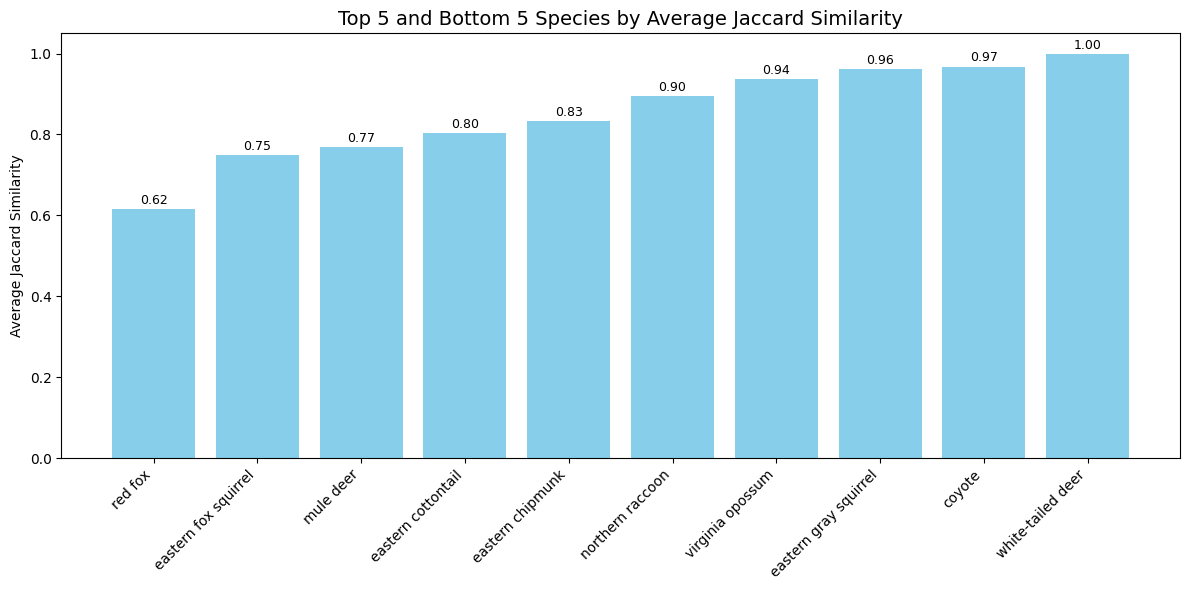

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Count frequency of each species
species_freq = df_merged['Common_Name'].value_counts()

# Step 2: Keep only species with at least 5000 sightings
threshold = 5000
frequent_species = species_freq[species_freq >= threshold].index.tolist()

# Step 3: Filter out species with 'human' or 'domestic' in the name
frequent_species_filtered = [
    s for s in frequent_species
    if 'human' not in s.lower() and 'domestic' not in s.lower() and 'mouse' not in s.lower()
]

# Step 4: Filter df_species_movement
df_species_movement_filtered = df_species_movement[
    df_species_movement['Common_Name'].isin(frequent_species_filtered)
]

# Step 5: Compute average Jaccard per species
jaccard_avg = (
    df_species_movement_filtered
    .groupby('Common_Name')['JaccardSimilarity']
    .mean()
    .sort_values()
)

# Step 6: Select top 5 and bottom 5
bottom_5 = jaccard_avg.head(5)
top_5 = jaccard_avg.tail(5)
combined = pd.concat([bottom_5, top_5])
combined = combined.sort_values()

# Step 7: Plot vertical bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(combined.index, combined.values, color='skyblue')
plt.title("Top 5 and Bottom 5 Species by Average Jaccard Similarity", fontsize=14)
plt.ylabel("Average Jaccard Similarity")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Annotate values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
             f"{height:.2f}", ha='center', va='bottom', fontsize=9)

plt.show()


In [26]:
def generate_species_movement_video(df, species_name, output_dir, fps=1):
    """
    Generate a GIF and MP4 video showing yearly movement of a species on a map.

    Parameters:
    - df: pandas DataFrame with at least ['Year', 'Latitude', 'Longitude', 'Common_Name']
    - species_name: string (e.g., 'red fox')
    - output_dir: string path to save the outputs
    - fps: frames per second (default: 1 = 1 second per frame)
    """

    # Step 1: Filter for species
    df_species = df[df['Common_Name'].str.lower() == species_name.lower()]
    df_species = df_species[['Year', 'Latitude', 'Longitude']].dropna()

    if df_species.empty:
        print(f"No data found for species: {species_name}")
        return

    # Step 2: GeoDataFrame
    geometry = [Point(xy) for xy in zip(df_species['Longitude'], df_species['Latitude'])]
    gdf = gpd.GeoDataFrame(df_species, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

    # Step 3: Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Step 4: Plot one frame per year
    frame_paths = []
    all_bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

    for year in sorted(gdf['Year'].unique()):
        yearly_gdf = gdf[gdf['Year'] == year]

        fig, ax = plt.subplots(figsize=(12, 10))
        ax.set_xlim(all_bounds[[0, 2]])
        ax.set_ylim(all_bounds[[1, 3]])
        yearly_gdf.plot(ax=ax, color='black', markersize=10)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

        ax.set_title(f"{species_name} Locations in {year}", fontsize=16)
        ax.set_axis_off()

        frame_path = os.path.join(output_dir, f"{species_name.replace(' ', '_')}_{year}.png")
        plt.savefig(frame_path, dpi=300, bbox_inches='tight')
        plt.close()
        frame_paths.append(frame_path)

    if not frame_paths:
        print("No frames created. Nothing to animate.")
        return

    # Step 5: Generate GIF
    gif_path = os.path.join(output_dir, f"{species_name.replace(' ', '_')}_movement.gif")
    images = [imageio.v2.imread(p) for p in frame_paths]
    imageio.mimsave(gif_path, images, fps=fps)
    print(f"✅ GIF saved at: {gif_path}")

    # Step 6: Generate MP4 video
    video_path = os.path.join(output_dir, f"{species_name.replace(' ', '_')}_movement.mp4")
    first_image = imageio.v2.imread(frame_paths[0])
    height, width, _ = first_image.shape

    writer = imageio.get_writer(video_path, fps=fps, codec='libx264')

    for img_path in frame_paths:
        img = imageio.v2.imread(img_path)
        writer.append_data(img)

    writer.close()
    print(f"✅ MP4 video saved at: {video_path}")

In [27]:
generate_species_movement_video(
    df=df_merged,
    species_name="red fox",
    output_dir=r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\red_fox",
    fps=1  # 1 frame every 2 seconds
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2850, 1738) to (2864, 1744) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ GIF saved at: C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\red_fox\red_fox_movement.gif
✅ MP4 video saved at: C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\red_fox\red_fox_movement.mp4


In [12]:
generate_species_movement_video(
    df=df_merged,
    species_name="white-tailed deer",
    output_dir=r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\white_tailed_deer",
    fps=0.5  # 1 frame every 2 seconds
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2850, 1742) to (2864, 1744) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ GIF saved at: C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\white_tailed_deer\white-tailed_deer_movement.gif
✅ MP4 video saved at: C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\white_tailed_deer\white-tailed_deer_movement.mp4


## Jaccard Index - Location Stability

#### Most stable locations = highest average Jaccard

- **Low Jaccard scores over time** → site has high species turnover

- **High Jaccard scores over time** → stable ecosystem

In [13]:
df_cluster_movement.groupby('Cluster_Agglo')['JaccardSimilarity'].mean().sort_values(ascending=False)

Cluster_Agglo
53     0.857877
135    0.830702
116    0.821142
118    0.798371
86     0.795789
26     0.793688
39     0.758170
23     0.751786
139    0.751273
85     0.748651
165    0.747181
154    0.745098
176    0.726087
47     0.717262
124    0.709127
180    0.706330
153    0.690651
72     0.687719
55     0.679604
27     0.673543
60     0.666228
16     0.654194
5      0.648588
9      0.647865
10     0.646578
137    0.644627
30     0.642201
133    0.640351
19     0.628790
195    0.627442
209    0.625618
191    0.620536
90     0.595871
57     0.595421
67     0.588319
164    0.579832
208    0.569792
99     0.556373
12     0.554487
183    0.510485
157    0.467857
Name: JaccardSimilarity, dtype: float64

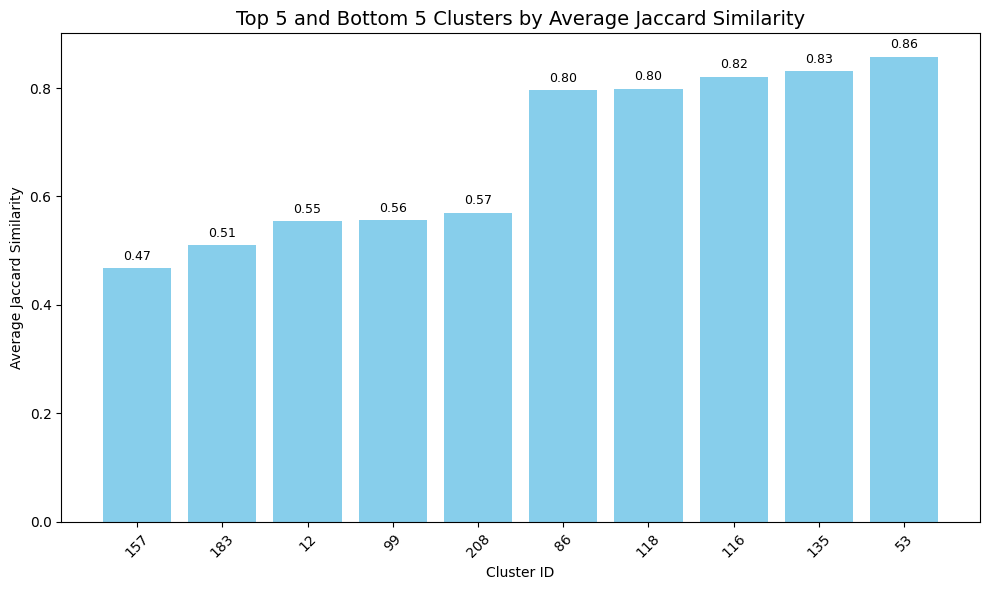

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Compute average Jaccard similarity per cluster
cluster_avg_jaccard = (
    df_cluster_movement.groupby('Cluster_Agglo')['JaccardSimilarity']
    .mean()
    .sort_values(ascending=False)
)

# Step 2: Select top 5 and bottom 5
top_5 = cluster_avg_jaccard.head(5)
bottom_5 = cluster_avg_jaccard.tail(5)

# Step 3: Combine and label
combined = pd.concat([top_5, bottom_5])
combined = combined.sort_values()  # sort for visual consistency

# Step 4: Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(combined.index.astype(str), combined.values, color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 5 and Bottom 5 Clusters by Average Jaccard Similarity", fontsize=14)
plt.xlabel("Cluster ID")
plt.ylabel("Average Jaccard Similarity")
plt.tight_layout()

# Optional: annotate values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()


In [40]:
def plot_species_presence_heatmap(df, cluster_id, output_path=None, show_plot=True):
    """
    Plots and optionally saves a species presence heatmap for a specific cluster.

    Parameters:
    - df: DataFrame with columns ['Cluster_Agglo_Updated', 'Species', 'Year']
    - cluster_id: int, the cluster to filter
    - output_path: (optional) full file path to save the plot (e.g., 'heatmap_189.png')
    - show_plot: bool, whether to display the plot with plt.show()
    
    Returns:
    - pivot_df: Binary matrix (species x year)
    """
    # Filter to selected cluster
    df_cluster = df[df['Cluster_Agglo'] == cluster_id]

    if df_cluster.empty:
        print(f"❌ No data found for Cluster {cluster_id}")
        return None

    # Pivot to get species-year matrix
    pivot_df = df_cluster.pivot_table(index='Common_Name', columns='Year', aggfunc='size', fill_value=0)
    pivot_df = (pivot_df > 0).astype(int)  # Binarize

    # Plot
    plt.figure(figsize=(12, max(6, 0.3 * pivot_df.shape[0])))

    sns.heatmap(
        pivot_df,
        cmap='YlGn',
        cbar=False,
        linewidths=0.3,
        linecolor='gray',
        annot=False,
        fmt='d'
    )

    plt.title(f"Species Presence Heatmap For Cluster {cluster_id}", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Common_Name", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=8)
    plt.tight_layout()

    # Save figure if path provided
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Heatmap saved at: {output_path}")

    if show_plot:
        plt.show()
    else:
        plt.close()

    return pivot_df

✅ Heatmap saved at: C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\cluster_53_heatmap_stable.png


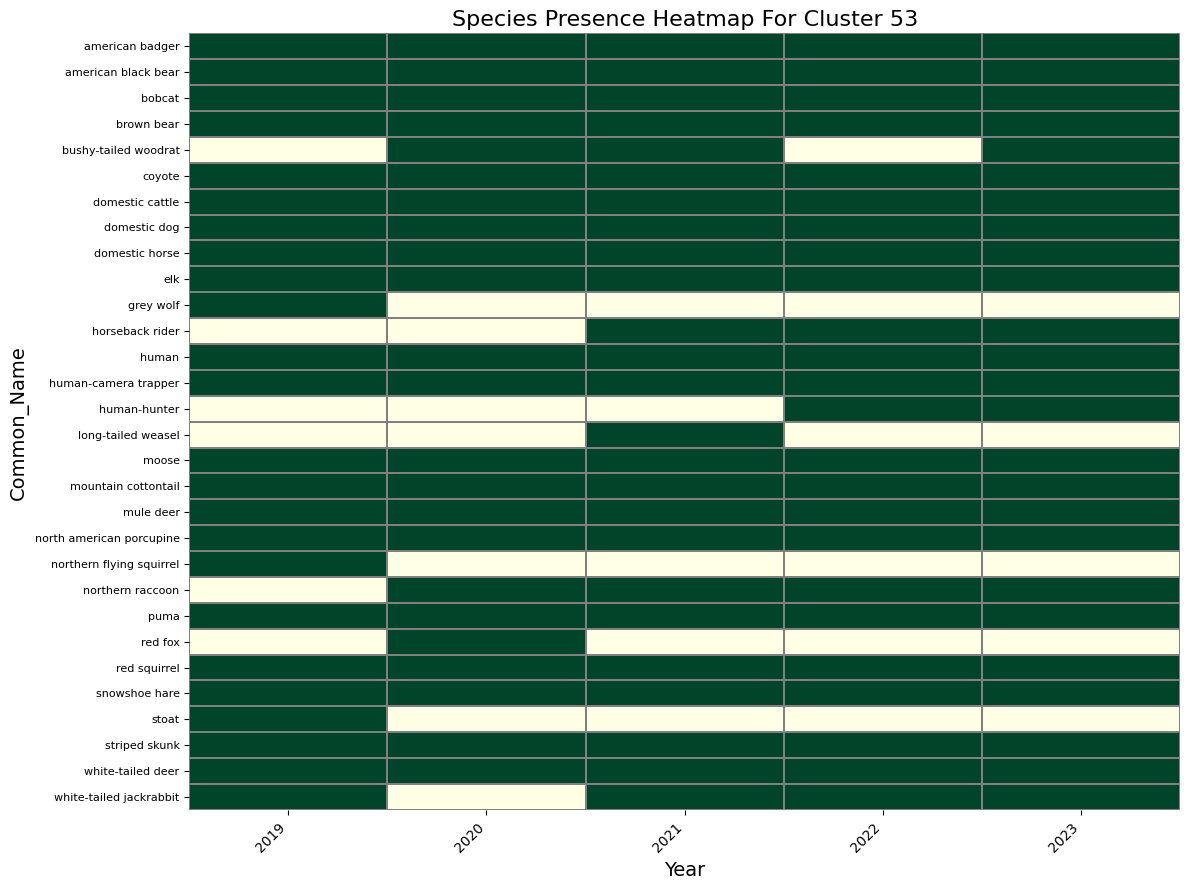

Year,2019,2020,2021,2022,2023
Common_Name,,,,,
american badger,1,1,1,1,1
american black bear,1,1,1,1,1
bobcat,1,1,1,1,1
brown bear,1,1,1,1,1
bushy-tailed woodrat,0,1,1,0,1
coyote,1,1,1,1,1
domestic cattle,1,1,1,1,1
domestic dog,1,1,1,1,1
domestic horse,1,1,1,1,1


In [42]:
plot_species_presence_heatmap(
    df=df,
    cluster_id=53,
    output_path=r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\cluster_53_heatmap_stable.png",
    show_plot=True
)

✅ Heatmap saved at: C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\cluster_183_heatmap_high_turnaround.png


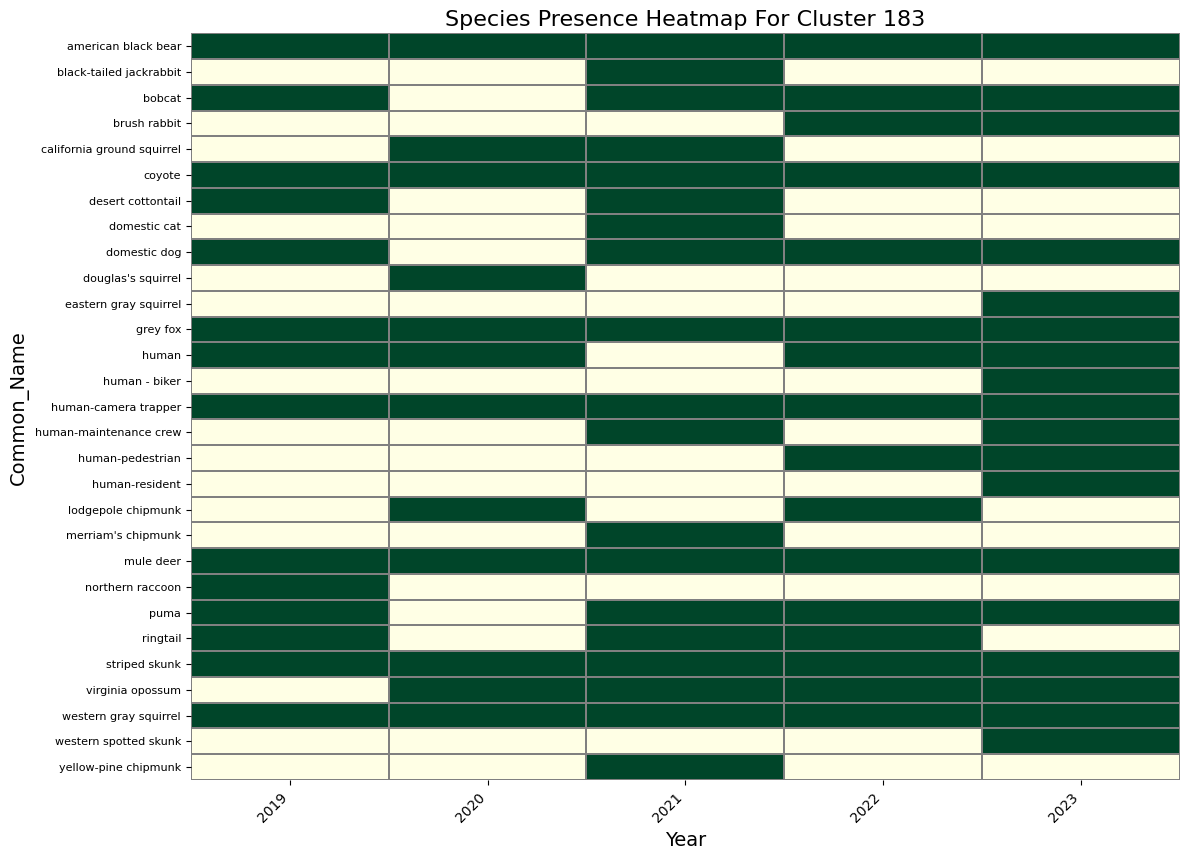

Year,2019,2020,2021,2022,2023
Common_Name,,,,,
american black bear,1,1,1,1,1
black-tailed jackrabbit,0,0,1,0,0
bobcat,1,0,1,1,1
brush rabbit,0,0,0,1,1
california ground squirrel,0,1,1,0,0
coyote,1,1,1,1,1
desert cottontail,1,0,1,0,0
domestic cat,0,0,1,0,0
domestic dog,1,0,1,1,1


In [45]:
plot_species_presence_heatmap(
    df=df,
    cluster_id=183,
    output_path=r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\cluster_183_heatmap_high_turnaround.png",
    show_plot=True
)

In [60]:
def plot_species_counts_by_cluster(df, cluster_ids, cluster_labels=None, output_path=None):
    """
    Plot distinct Common_Name count per year for one or more clusters,
    and annotate with Year-over-Year (YoY) percentage change.

    Parameters:
    - df: DataFrame with columns ['Cluster_Agglo', 'Common_Name', 'Year']
    - cluster_ids: list of ints (e.g., [189, 74])
    - cluster_labels: optional list of names for legend (same length as cluster_ids)
    - output_path: optional path to save plot image (e.g., "cluster_species_bar.png")
    """

    # Default labels = "Cluster {id}"
    if cluster_labels is None:
        cluster_labels = [f"Cluster {cid}" for cid in cluster_ids]

    # Collect distinct species counts per year
    cluster_yearly_counts = {}
    all_years = set()

    for cid in cluster_ids:
        cluster_df = df[df['Cluster_Agglo'] == cid]
        species_per_year = (
            cluster_df.groupby('Year')['Common_Name']
            .nunique()
            .sort_index()
        )
        cluster_yearly_counts[cid] = species_per_year
        all_years.update(species_per_year.index)

    # Sort and align all years
    all_years = sorted(all_years)
    x = np.arange(len(all_years))
    bar_width = 0.8 / len(cluster_ids)  # adaptive width

    # Plot
    plt.figure(figsize=(14, 6))

    for i, cid in enumerate(cluster_ids):
        counts = cluster_yearly_counts[cid].reindex(all_years, fill_value=0)
        plt.bar(
            x + i * bar_width - bar_width * (len(cluster_ids) - 1) / 2,
            counts.values,
            width=bar_width,
            label=cluster_labels[i]
        )

        # Annotate YoY change
        yoy_change = counts.pct_change().fillna(0) * 100
        for j, (val, change) in enumerate(zip(counts.values, yoy_change.values)):
            if j == 0:
                continue  # skip first year
            sign = "+" if change >= 0 else ""
            plt.text(
                x[j] + i * bar_width - bar_width * (len(cluster_ids) - 1) / 2,
                val + 0.5,
                f"{sign}{change:.1f}%",
                ha='center',
                va='bottom',
                fontsize=14
            )

    # Formatting
    plt.title('Distinct Common_Name Per Year By Cluster', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Count of Distinct Species', fontsize=14)
    plt.xticks(x, all_years)
    plt.legend()
    # Adjust y-axis to prevent annotation overlap
    max_count = max([cluster_yearly_counts[cid].max() for cid in cluster_ids])
    plt.ylim(0, max_count + 5)
    
    plt.tight_layout()

    # Save if required
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved at: {output_path}")

    plt.show()


✅ Plot saved at: C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\species_count_189_74.png


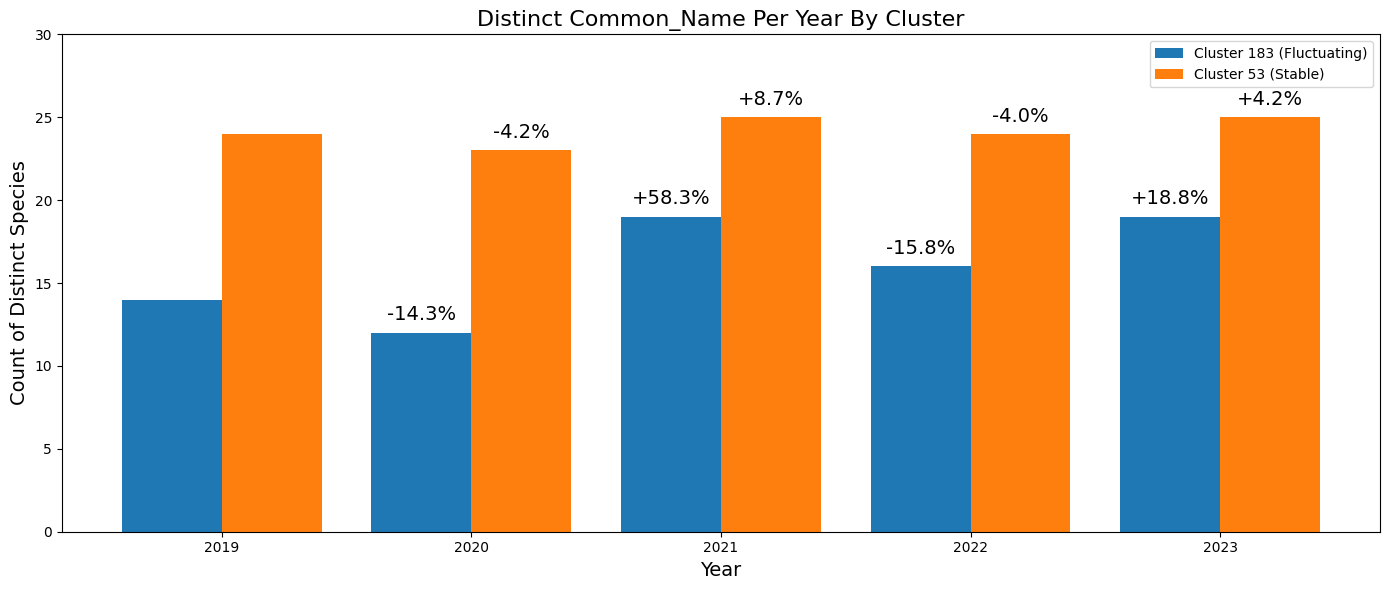

In [61]:
plot_species_counts_by_cluster(
    df=df,
    cluster_ids=[183, 53],
    cluster_labels=["Cluster 183 (Fluctuating)", "Cluster 53 (Stable)"],
    output_path=r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\species_count_189_74.png"
)
